In [219]:
import numpy as np
import jax
import jax.numpy as jnp
from  matplotlib import pyplot as plt

In [220]:
#TODO: think properly about inputs-outputs.

def rand_volume(shape, dimensions, radius, sigma = 0.1):
    """Generate a random smoothed spherical volume

    Parameters
    ----------
    shape : 3 x 1 array
        Dimensions of the volume, in number of elements
    dimensions: 3 x 1 array
        Dimensions of the volume, in units (e.g. Angst?)
    radius: float
        Radius of spherical object
    sigma: float
        Sigma for the Gaussian window 

    Returns
    -------
    vol
        the volume
    """
    
    Nx, Ny, Nz = shape
    vol = np.random.randn(Nx, Ny, Nz) + 2
    #vol = np.ones(shape) + 5
    vol[vol < 0] = 0
    
    Lx, Ly, Lz = dimensions  
    dx, dy, dz = dimensions/shape # "pixel" size
    

    # By adjusting the interval by half a pixel on each side
    # we ensure the sampling locations are 
    # the centres of the pixels
    coords_x = np.linspace(-Lx/2 + dx/2, Lx/2 - dx/2, Nx)
    coords_y = np.linspace(-Ly/2 + dy/2, Ly/2 - dy/2, Ny)
    coords_z = np.linspace(-Lz/2 + dz/2, Lz/2 - dz/2, Nz) 
    X, Y, Z = np.meshgrid(coords_x, coords_y, coords_z)
    
    mask = create_mask(X, Y, Z, radius) 
    
    return low_pass_filter(mask*vol, X, Y, Z, sigma), X, Y, Z

In [221]:
def create_mask(X, Y, Z, radius):    
    mask = np.ones(X.shape)
    r = np.sqrt(X**2 + Y**2 + Z**2)
    print(X.shape)
    print(radius)
    mask[r > radius] = 0
    return mask

In [222]:
def low_pass_filter(vol, X, Y, Z, sigma):
    gauss = np.exp(-(X**2 + Y**2 + Z**2)/(2*sigma))
    gauss = gauss/max(gauss.ravel())
    gauss = np.fft.fftshift(gauss)
    
    low_pass_vol = np.fft.ifftn(np.fft.fftn(vol) * gauss)
    return np.real(low_pass_vol)

In [223]:
def volume_fourier(vol, dimensions, shape_f = None):
    """Calculate the FFT of the volume and return the frequency coordinates

    Parameters
    ----------
    vol : 
        Volume in spatial domain
    dimensions: 3 x 1 array
        Spatial dimensions of the volume, in units (e.g. Angst?)
    shape_f: 3 x 1 array
        Shape of the Fourier volume

    Returns
    -------
    vol_f
        the Fourier volume
    X_f, Y_f, Z_f
        Fourier points
    """

    if shape_f == None:
        shape_f = vol.shape

    vol_f = np.fft.fftn(vol, shape_f)
    
    Nx, Ny, Nz = vol.shape
    Nx_f, Ny_f, Nz_f = shape_f
    dx, dy, dz = dimensions/vol.shape # "pixel" size
    
    x_freq = np.fft.fftfreq(Nx_f, dx)
    y_freq = np.fft.fftfreq(Ny_f, dy)
    z_freq = np.fft.fftfreq(Nz_f, dz)
    X_f, Y_f, Z_f = np.meshgrid(x_freq, y_freq, z_freq)
    
    return vol_f, X_f, Y_f, Z_f

In [224]:
# Rotation around the z axis to begin with
def rotate_z(X, Y, Z, alpha):
    rot_mat = np.array([[np.cos(alpha), -np.sin(alpha), 0],
                       [np.sin(alpha), np.cos(alpha), 0],
                       [0, 0, 1]])
    
    coords = np.array([X.flatten(), Y.flatten(), Z.flatten()])
    coords_r = np.matmul(rot_mat, coords)
    
    X_r = coords_r[0,:].reshape(X.shape)
    Y_r = coords_r[1,:].reshape(Y.shape)
    Z_r = coords_r[2,:].reshape(Z.shape)
    
    return X_r, Y_r, Z_r

In [225]:
# Euler angles
def rotate(X, Y, Z, alpha, beta, gamma):
    Rx = np.array([[1, 0, 0], 
                   [0, np.cos(alpha), -np.sin(alpha)],
                   [0, np.sin(alpha), np.cos(alpha)]])
    
    Ry = np.array([[np.cos(beta), 0, np.sin(beta)],
                   [0, 1, 0],
                   [-np.sin(beta), 0, np.cos(beta)]])

    Rz = np.array([[np.cos(gamma), -np.sin(gamma), 0],
                    [np.sin(gamma), np.cos(gamma), 0],
                    [0, 0, 1]])
    
    coords = np.array([X.flatten(), Y.flatten(), Z.flatten()])
    coords_r = Rz @ Ry @ Rx @ coords
    
    X_r = coords_r[0,:].reshape(X.shape)
    Y_r = coords_r[1,:].reshape(Y.shape)
    Z_r = coords_r[2,:].reshape(Z.shape)
    
    return X_r, Y_r, Z_r

In [226]:
nx = 129
shape = nx * np.ones(3, dtype=np.int32)
length = 5
dimensions = 5 * np.ones(3)
radius = 2
sigma = 1

v, X, Y, Z = rand_volume(shape, dimensions, radius, sigma)

(129, 129, 129)
2


Text(0.5, 1.0, 'Volume slice')

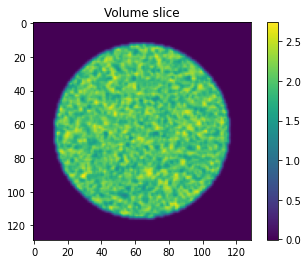

In [227]:
plt.imshow(v[:,:,int(np.floor(v.shape[2]/2))])
plt.colorbar()
plt.title('Volume slice')

In [228]:
v_f, X_f, Y_f, Z_f = volume_fourier(v, dimensions)
v_f.shape

(129, 129, 129)

Text(0.5, 1.0, 'Vol FFT slice')

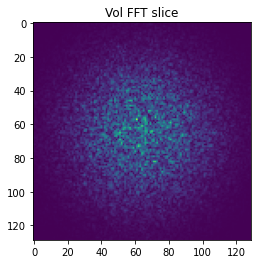

In [229]:
plt.imshow(np.fft.fftshift(abs(v_f[:,:,int(np.floor(v.shape[2]/2))])))
plt.title('Vol FFT slice')

Text(0.5, 1.0, 'X_f coords')

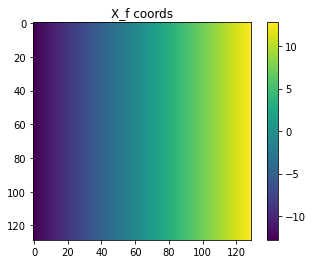

In [256]:
plt.imshow(np.fft.fftshift(X_f[:,:,0]))
plt.colorbar()
plt.title('X_f coords')

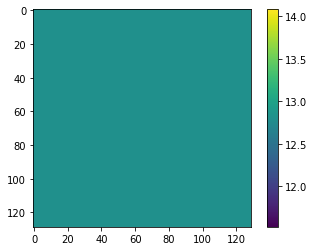

In [384]:
alpha = np.pi/2
beta = 0
gamma = 0
X_fr, Y_fr, Z_fr = rotate(X_f, Y_f, Z_f, alpha, beta, gamma)
plt.imshow(np.fft.fftshift(Y_fr[:,:,65]))
plt.colorbar()

In [382]:
np.min(Y_fr[:,:,2].flatten())

-0.4000000000000008

In [341]:
X_fr1, _, _ = rotate(X_f, Y_f, Z_f, 0,  np.pi/2, 0)
X_fr2, _, _ = rotate(X_f, Y_f, Z_f, 0, -np.pi/2, 0)
idx = -1
X_fr1[:,:,idx]-X_fr2[:,:,idx]



array([[-0.2, -0.2, -0.2, ..., -0.2, -0.2, -0.2],
       [-0.2, -0.2, -0.2, ..., -0.2, -0.2, -0.2],
       [-0.2, -0.2, -0.2, ..., -0.2, -0.2, -0.2],
       ...,
       [-0.2, -0.2, -0.2, ..., -0.2, -0.2, -0.2],
       [-0.2, -0.2, -0.2, ..., -0.2, -0.2, -0.2],
       [-0.2, -0.2, -0.2, ..., -0.2, -0.2, -0.2]])

# ==================

In [232]:
x = np.arange(10)
y = np.arange(10,20)
z = np.arange(20,30)

In [233]:
for i in zip(x,y,z):
    xx = np.array(i)

In [234]:
x = np.array([1,10])
A = np.array([[1,2],[3,4]])
y = np.matmul(A,x)

In [235]:
y

array([21, 43])

In [236]:
130+120+30+30+40+200+250+10+110+140

1060

In [237]:
x = np.random.randn(5,6,7)
y = np.random.randn(5,6,7)
z = np.random.randn(5,6,7)

In [238]:
c = np.array([x.flatten(), y.flatten(), z.flatten()])
c.shape

(3, 210)

In [239]:
c[:,1]

array([ 1.31560788, -1.1653377 , -1.84373461])

In [240]:
[x[0,0,1], y[0,0,1], z[0,0,1]]

[1.3156078781373026, -1.1653376988492123, -1.8437346144981412]

In [241]:
xr = c[0,:]
yr = c[1,:]
zr = c[2,:]
[xr[1], yr[1], zr[1]]

[1.3156078781373026, -1.1653376988492123, -1.8437346144981412]

In [242]:
xr.reshape(x.shape) - x

array([[[0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
    

In [243]:
X = np.array([[[1,2,120],[3,4,340]], [[5,6,560],[7,8,780]]])
Y = np.array([[[10,20, 1200],[30,40, 3400]], [[50,60, 5600],[70,80, 7800]]])
C = np.array([X,Y])

In [244]:
target = np.array([X.flatten(), Y.flatten()])
target

array([[   1,    2,  120,    3,    4,  340,    5,    6,  560,    7,    8,
         780],
       [  10,   20, 1200,   30,   40, 3400,   50,   60, 5600,   70,   80,
        7800]])

In [245]:
target.shape

(2, 12)

In [246]:
Xr = target[0,:]
Yr = target[1,:]
Xr.reshape(X.shape) - X

array([[[0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0]]])

In [247]:
X

array([[[  1,   2, 120],
        [  3,   4, 340]],

       [[  5,   6, 560],
        [  7,   8, 780]]])

In [248]:
Xr.reshape(X.shape)

array([[[  1,   2, 120],
        [  3,   4, 340]],

       [[  5,   6, 560],
        [  7,   8, 780]]])